In [22]:
# making fake data 
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from data.sef import read

data = read("D:\\pd_data\\band1_35Hz_HC_EC\\EC_CT063_20130426_1337_Stitch_band_1_35.sef")
print(data[0])
sfreq = 1000  # Sampling frequency

[['version:' 'SE01']
 ['number of channels:' '213']
 ['number of aux channels:' '1']
 ['number of timeframes:' '177900']
 ['samplingrate:' '1000.0']
 ['year:' '2013']
 ['month:' '4']
 ['day:' '26']
 ['hour:' '15']
 ['minute:' '5']
 ['second:' '23']
 ['millisecond:' '322']]


(177900, 213)
E1
177900


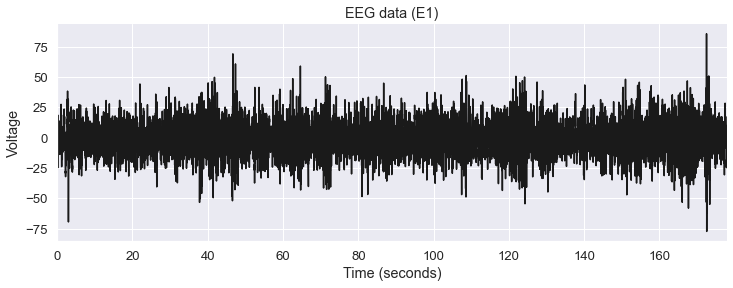

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

print(data[2].shape)
print(data[1][0])

part_data = np.array(data[2][:,0])

# Define sampling frequency and time vector
sf = 1000.
print(part_data.size)
time = np.arange(part_data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, part_data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('EEG data (E1)')
sns.despine()

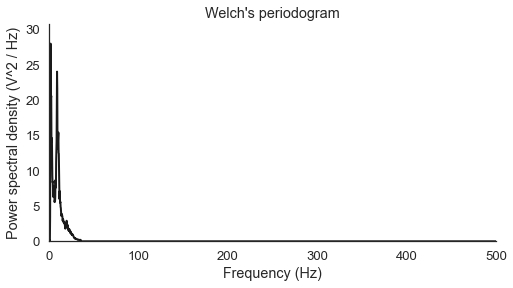

In [66]:
from scipy import signal

# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(part_data, sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

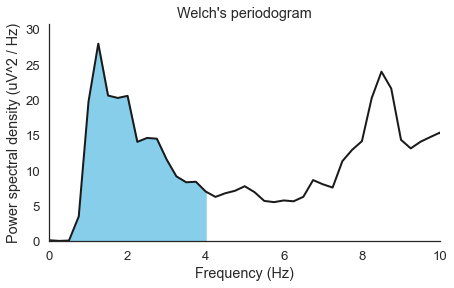

In [67]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [68]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 49.239 uV^2


In [69]:
# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

Relative delta power: 0.292


In [70]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [73]:
# Define the duration of the window to be 4 seconds
win_sec = 4

# Delta/beta ratio based on the absolute power
db = bandpower(part_data, sf, [0.5, 4], win_sec) / bandpower(part_data, sf, [12, 30], win_sec)

# Delta/beta ratio based on the relative power
db_rel = bandpower(part_data, sf, [0.5, 4], win_sec, True) / bandpower(part_data, sf, [12, 30], win_sec, True)

print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

Delta/beta ratio (absolute): 1.395
Delta/beta ratio (relative): 1.395


In [74]:
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [77]:
# Multitaper delta power
bp = bandpower(part_data, sf, [0.5, 4], 'multitaper')
bp_rel = bandpower(part_data, sf, [0.5, 4], 'multitaper', relative=True)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel)

# Delta-beta ratio
# One advantage of the multitaper is that we don't need to define a window length.
db = bandpower(part_data, sf, [0.5, 4], 'multitaper') / bandpower(part_data, sf, [12, 30], 'multitaper')
# Ratio based on the relative power
db_rel = bandpower(part_data, sf, [0.5, 4], 'multitaper', relative=True) / \
                    bandpower(part_data, sf, [12, 30], 'multitaper', relative=True)
print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

<ipython-input-74-c9c5d0550e94>:46: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  normalization='full', verbose=0)
<ipython-input-74-c9c5d0550e94>:46: RuntimeWarning: Not adaptively combining the spectral estimators due to a low number of tapers (1 < 3).
  normalization='full', verbose=0)
<ipython-input-74-c9c5d0550e94>:46: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  normalization='full', verbose=0)
<ipython-input-74-c9c5d0550e94>:46: RuntimeWarning: Not adaptively combining the spectral estimators due to a low number of tapers (1 < 3).
  normalization='full', verbose=0)


Absolute delta power: 42.874
Relative delta power: 0.219


<ipython-input-74-c9c5d0550e94>:46: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  normalization='full', verbose=0)
<ipython-input-74-c9c5d0550e94>:46: RuntimeWarning: Not adaptively combining the spectral estimators due to a low number of tapers (1 < 3).
  normalization='full', verbose=0)
<ipython-input-74-c9c5d0550e94>:46: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  normalization='full', verbose=0)
<ipython-input-74-c9c5d0550e94>:46: RuntimeWarning: Not adaptively combining the spectral estimators due to a low number of tapers (1 < 3).
  normalization='full', verbose=0)
<ipython-input-74-c9c5d0550e94>:46: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  normalization='full', verbose=0)
<ipython-input-74-c9c5d0550e94>:46: RuntimeWarning: Not adaptively combining the spectral estimators due to a low number of tapers (1 < 3).
  normalization='full', verbose=0)


Delta/beta ratio (absolute): 1.423
Delta/beta ratio (relative): 1.423


<ipython-input-74-c9c5d0550e94>:46: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  normalization='full', verbose=0)
<ipython-input-74-c9c5d0550e94>:46: RuntimeWarning: Not adaptively combining the spectral estimators due to a low number of tapers (1 < 3).
  normalization='full', verbose=0)


<ipython-input-78-533742846cfa>:26: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  normalization='full', verbose=0)
<ipython-input-78-533742846cfa>:26: RuntimeWarning: Not adaptively combining the spectral estimators due to a low number of tapers (1 < 3).
  normalization='full', verbose=0)
C:\Users\Normand\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:40: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\Normand\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:41: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and 

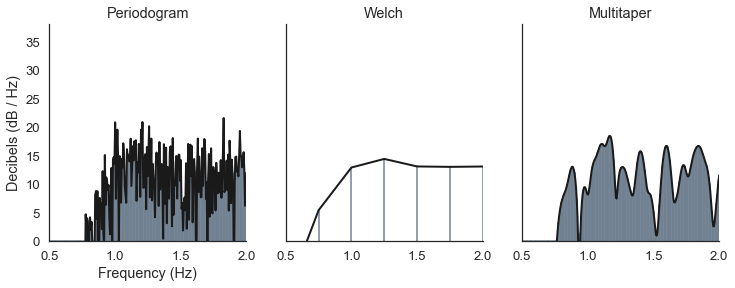

In [78]:
def plot_spectrum_methods(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    from mne.time_frequency import psd_array_multitaper
    from scipy.signal import welch, periodogram
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs, psd = periodogram(data, sf)
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    psd_mt, freqs_mt = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd = 10 * np.log10(psd)
        psd_welch = 10 * np.log10(psd_welch)
        psd_mt = 10 * np.log10(psd_mt)
        sharey = True

    # Start plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax1.stem(freqs, psd, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax2.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax3.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax1.plot(freqs, psd, lw=lw, color=lc)
    ax2.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    ax3.plot(freqs_mt, psd_mt, lw=lw, color=lc)
    # Labels and axes
    ax1.set_xlabel('Frequency (Hz)')
    if not dB:
        ax1.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax1.set_ylabel('Decibels (dB / Hz)')
    ax1.set_title('Periodogram')
    ax2.set_title('Welch')
    ax3.set_title('Multitaper')
    if band is not None:
        ax1.set_xlim(band)
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)
    sns.despine()

# Example: plot the 0.5 - 2 Hz band
plot_spectrum_methods(part_data, sf, 4, [0.5, 2], dB=True)

In [92]:
# delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–12 Hz), beta (12–30 Hz), and gamma (30–100 Hz).
import warnings
import time

def bandpower(data, sf, band, method='welch'):
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        nperseg = (2 / low) * sf
        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            psd, freqs = psd_array_multitaper(data, sf, adaptive=True, n_jobs=4,
                                              normalization='full', verbose=0)

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    return psd[idx_band]

bands = {"delta": [0.5,4],
         "theta": [4,8],
         "alpha": [8,12],
         "beta" : [12,30],
         "gamma": [30,100]}

# for 4 jobs: Total Time: 469.1608521938324
# for 8 jobs: Total Time: 474.18307995796204
# for 2 jobs: Total Time: 481.47154450416565

# TODO:
# transpose it once we can append to it 

(213, 623)
(213, 712)
(213, 711)
(213, 3203)
(213, 12453)
Total Time: 481.47154450416565


In [100]:
import os

pd_dir = "D:/pd_data/band1_35Hz_PD_EC"
hc_dir = "D:/pd_data/band1_35Hz_HC_EC"

pd_files = [os.path.join(pd_dir,x) for x in os.listdir(pd_dir) if ".sef" == os.path.splitext(x)[1]]
hc_files = [os.path.join(hc_dir,x) for x in os.listdir(hc_dir) if ".sef" == os.path.splitext(x)[1]]

print(len(pd_files))
print(len(hc_files))

total_combined = pd_files + hc_files

start = time.time()
bands_to_array = {}
bands_to_array_lengths = {}

for filepath in total_combined:
    data = read(filepath)
    for band in bands:
        new_data = []
        for i in range(data[2].shape[1]):
            part_data = np.array(data[2][:,i])
            band_data = bandpower(part_data, sf, bands[band], 'multitaper')
            new_data.append(band_data)
        new_data = np.array(new_data)
        if band not in bands_to_array:
            bands_to_array[band] = new_data
            bands_to_array_lengths[band] = [new_data.shape[1]]
        else:
            bands_to_array[band] = np.append(bands_to_array[band] , new_data, axis=1)
            bands_to_array_lengths[band].append(new_data.shape[1])
print(f"Total Time: {time.time()-start}")

44
24
Total Time: 31609.841184854507


In [109]:
print(bands_to_array["gamma"].shape)
print(bands_to_array_lengths)

for band in bands:
    np.save(band, bands_to_array[band].transpose())
    np.save(f"{band}_length", np.array(bands_to_array_lengths[band]))

(213, 846596)
{'delta': [623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 617, 623, 623, 623, 623, 623, 623, 617, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623], 'theta': [712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 706, 712, 712, 712, 712, 712, 712, 706, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712], 'alpha': [711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 705, 711, 711, 711, 711, 711, 711, 705, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711